In [1]:
import sys
path = ".."
if path not in sys.path:
    sys.path.append(path)

In [2]:
from lieposenet.data.seven_scenes import SevenScenes

In [3]:
import torchvision.transforms as transforms
import torch
import torch.nn as nn
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, HuberRegressor

In [4]:
5.222627479256024552e-01 4.620521564670138082e-01 4.212473626365915158e-01
5.550322239689903236e-02 5.943252514694064015e-02 5.525370066993806617e-02

SyntaxError: invalid syntax (<ipython-input-4-c1b6e3c2c2fe>, line 1)

In [5]:
x = 5.525370066993806617e-02
x ** 0.5

0.23506105732327945

In [6]:
image_transform = transforms.Compose([
    transforms.Resize(256),
    # transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
dataset = SevenScenes("fire", "../data/7scenes", True, image_transform, mode=0, seed=0, sequences=[4])

In [7]:
data_loader = torch.utils.data.DataLoader(dataset, 32, True, pin_memory=True, num_workers=4)

In [8]:
resnet = models.resnet34(pretrained=True)
resnet_parts = list(resnet.children())
model = nn.Sequential(*resnet_parts[:-1]).cuda()

In [9]:
features = np.zeros([0, 512])
positions = np.zeros([0, 4, 4])
for batch in data_loader:
    result = model(batch["image"].cuda())[:, :, 0, 0].cpu().detach().numpy()
    features = np.concatenate([features, result], axis=0)
    positions = np.concatenate([positions, batch["position"]], axis=0)

In [10]:
def get_sequence_data(sequence):
    image_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
#     transforms.Normalize(mean=[0.522, 0.462, 0.421],
#                          std=[0.235, 0.243, 0.235])
    ])
    dataset = SevenScenes("fire", "../data/7scenes", True, image_transform, mode=0, seed=0, sequences=[sequence])
    data_loader = torch.utils.data.DataLoader(dataset, 32, True, pin_memory=True, num_workers=4)
    features = np.zeros([0, 512])
    positions = np.zeros([0, 4, 4])
    for batch in data_loader:
        result = model(batch["image"].cuda())[:, :, 0, 0].cpu().detach().numpy()
        features = np.concatenate([features, result], axis=0)
        positions = np.concatenate([positions, batch["position"]], axis=0)
    return features, positions

In [11]:
positions.shape

(1000, 4, 4)

(array([116.,  80., 132., 184., 115.,  37.,  59., 100., 118.,  59.]),
 array([-0.98283899, -0.77305015, -0.56326132, -0.35347248, -0.14368365,
         0.06610519,  0.27589402,  0.48568286,  0.69547169,  0.90526053,
         1.11504936]),
 <a list of 10 Patch objects>)

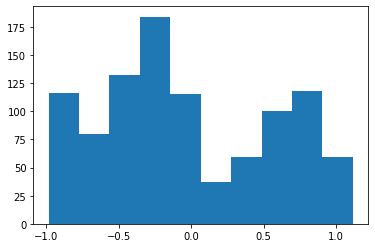

In [12]:
plt.hist(positions[:, 0, 3])

In [131]:
x = np.ones(10)

TypeError: matmul: axis can only be used with a single shared core dimension, not with the 3 distinct ones implied by signature (n?,k),(k,m?)->(n?,m?).

In [13]:
def invert_positions(positions):
    result = np.zeros_like(positions)
    result[:, :3, :3] = np.transpose(positions[:, :3, :3], (0, 2, 1))
    result[:, :3, 3] = -np.einsum('ijk, ik->ij', result[:, :3, :3], positions[:, :3, 3])
    result[:, 3, 3] = 1
    return result

In [14]:
y = features[:, 0]
inv_posistions = invert_positions(positions)
x = np.concatenate([inv_posistions[:, :3, :].reshape(-1, 12),
                    inv_posistions[:, :3, :].reshape(-1, 12) * y[:, None]], axis=1)

In [15]:
def get_linear_regression(features, positions):
    inv_posistions = invert_positions(positions)
    y = inv_posistions[:, :3, :].reshape(-1, 12)[:, 11]
    x = np.concatenate([inv_posistions[:, :3, :].reshape(-1, 12)[:, :11],
                        inv_posistions[:, :3, :].reshape(-1, 12)[:, :12] * features[:, 0][:, None]], axis=1)
    reg = LinearRegression().fit(x, y)
    print(reg.score(x, y))
    return reg

def test_regression(reg, features, positions):
    inv_posistions = invert_positions(positions)
    y = inv_posistions[:, :3, :].reshape(-1, 12)[:, 11]
    x = np.concatenate([inv_posistions[:, :3, :].reshape(-1, 12)[:, :11],
                        inv_posistions[:, :3, :].reshape(-1, 12)[:, :12] * features[:, 0][:, None]], axis=1)
    return reg.score(x, y)

In [16]:
reg = LinearRegression().fit(x, y)
print(reg.score(x, y))
print(np.round(reg.coef_, 2))

0.9999702937367889
[-1.09 -0.09  0.06 -0.   -0.03 -0.43 -0.86 -0.03  0.08 -0.69  0.69 -0.01
  1.36  0.1  -0.04  0.    0.02  0.57  1.06  0.04 -0.07  0.85 -0.88  0.02]


In [17]:
reg = LinearRegression().fit(x, y)
reg.score(x, y)
print(np.round(reg.coef_, 2))

[-1.09 -0.09  0.06 -0.   -0.03 -0.43 -0.86 -0.03  0.08 -0.69  0.69 -0.01
  1.36  0.1  -0.04  0.    0.02  0.57  1.06  0.04 -0.07  0.85 -0.88  0.02]


In [18]:
reg = LinearRegression().fit(x, y)
reg.score(x, y)
print(np.round(reg.coef_, 2))

[-1.09 -0.09  0.06 -0.   -0.03 -0.43 -0.86 -0.03  0.08 -0.69  0.69 -0.01
  1.36  0.1  -0.04  0.    0.02  0.57  1.06  0.04 -0.07  0.85 -0.88  0.02]


In [19]:
reg = LinearRegression().fit(x, y)
reg.score(x, y)
print(np.round(reg.coef_, 2))

[-1.09 -0.09  0.06 -0.   -0.03 -0.43 -0.86 -0.03  0.08 -0.69  0.69 -0.01
  1.36  0.1  -0.04  0.    0.02  0.57  1.06  0.04 -0.07  0.85 -0.88  0.02]


In [20]:
features1, positions1 = get_sequence_data(1)

In [21]:
features2, positions2 = get_sequence_data(2)

In [22]:
features3, positions3 = get_sequence_data(3)

In [23]:
features4, positions4 = get_sequence_data(4)

In [24]:
reg1 = get_linear_regression(features1, positions1)
print(np.round(reg1.coef_, 2))

0.9905027212582801
[ 1.852e+01  1.850e+00  3.800e-01 -2.200e-01 -6.100e-01  3.320e+00
  9.530e+00 -1.300e+00 -1.000e-02  3.490e+00 -1.647e+01 -1.471e+01
 -2.090e+00  3.150e+00  1.500e-01 -1.450e+00 -5.600e-01 -7.110e+00
  1.300e+00  3.030e+00 -1.100e+00  1.343e+01  9.800e-01]


In [25]:
test_regression(reg1, features2, positions2)

-1.9078114620286786

In [26]:
reg2 = get_linear_regression(features2, positions2)
print(np.round(reg2.coef_, 2))

0.9823999153799682
[-4.77 -1.69 11.   -0.03 -4.74  9.74 -4.26 -0.83 10.32  2.84  1.2   3.62
  1.05 -3.72  0.14  1.59 -2.45  4.1   0.67 -3.9   0.78 -0.24  0.82]


In [27]:
from sklearn.linear_model import BayesianRidge, Lasso,ARDRegression, Ridge, ElasticNet, RidgeCV


In [28]:
def get_linear_regression_angles(features, positions, global_point=np.array([0, 1, 1.5, 1])):
    inv_posistions = invert_positions(positions)
    transformed_point = np.einsum('ijk, k->ij', inv_posistions, global_point)
    mask = transformed_point[:, 2] > 0.5
    y = (transformed_point[:, 0] / transformed_point[:, 2])[mask]
    print(len(y))
    if len(y) < 0.9 * len(features):
        return None, None
    x = features[mask, :]
    x = np.concatenate([x, x ** 2], axis=1)
    regx = BayesianRidge().fit(x, y)
    print(regx.score(x, y))
    y = (transformed_point[:, 1] / transformed_point[:, 2])[mask]
    regy = BayesianRidge().fit(x, y)
    print(regy.score(x, y))
    return regx, regy

In [29]:
f = np.concatenate([features1, features2], axis=0)
p = np.concatenate([positions1, positions2], axis=0)
regx, regy = get_linear_regression_angles(f, p)

2000
0.9603340417270131
0.973935706374139


(array([ 68., 171., 263., 197., 130.,  79.,  52.,  26.,   9.,   5.]),
 array([0.03043666, 0.27733692, 0.52423718, 0.77113744, 1.01803769,
        1.26493795, 1.51183821, 1.75873847, 2.00563872, 2.25253898,
        2.49943924]),
 <a list of 10 Patch objects>)

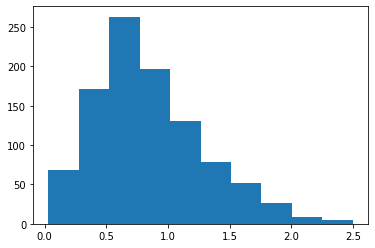

In [30]:
plt.hist(y)

In [151]:
def test_regression_angles(regx, regy, features, positions, global_point=np.array([0, 1, 1.5, 1])):
    n = len(features)
    inv_posistions = invert_positions(positions)
    transformed_point = np.einsum('ijk, k->ij', inv_posistions, global_point)
    mask = transformed_point[:, 2] > 0.2
    true_x = (transformed_point[:, 0] / transformed_point[:, 2])[mask]
    true_y = (transformed_point[:, 1] / transformed_point[:, 2])[mask]
    features = features[mask, :]
    features = np.concatenate([features, features ** 2], axis=1)
    pred_x = np.zeros(n)
    pred_x[mask] = regx.predict(features)
#     pred_x[mask] = true_x
    pred_y = np.zeros(n)
    pred_y[mask] = regy.predict(features)
#     pred_y[mask] = true_y
    print(len(true_x))
    print("score x ", regx.score(features, true_x))
    print("error x ", np.mean(np.abs(true_x - pred_x[mask])) * 180 / np.pi)
    print("score y ", regy.score(features, true_y))
    print("error y ", np.mean(np.abs(true_y - pred_y[mask])) * 180 / np.pi)
    return pred_x, pred_y, mask

In [32]:
test_regression_angles(regx, regy, features4, positions4);

1000
score x  0.608481334846013
error x  7.893435101433599
score y  0.572515863041177
error y  7.772263282737108


In [33]:
global_points = np.random.rand(100, 4)
global_points[:, 3] = 1
global_points[:, 0] = 2 * global_points[:, 0] - 0.5
global_points[:, 1] = 2 * global_points[:, 1] - 0.5
global_points[:, 2] = 2 * global_points[:, 2] - 0.5

In [161]:
n = 5
x, y, z =  np.meshgrid(np.linspace(-1.5, 2, n), np.linspace(-2, 0.5, n), np.linspace(-0.5, 2, n))
global_points = np.ones((n ** 3, 4))
global_points[:, 0] = x.flatten()
global_points[:, 1] = y.flatten()
global_points[:, 2] = z.flatten()

In [162]:
# global_points = np.array([
#     [1, 0, 1.5, 1],
#     [1, 1, 1.5, 1],
#     [0, 1, 1.5, 1],
#     [0, 1, 1, 1],
#     [1, 0.5, 1.5, 1],
#     [0.5, 0.5, 1.5, 1],
#     [-1, 0.5, 1.5, 1],
#     [0.5, -0.5, 1.5, 1],
#     [0.5, 0.5, 1, 1],
#     [0.5, 0.5, 2, 1],
#     [2, 1, 1.5, 1],
#     [1, 2, 1.5, 1],
# ])
global_points1 = []
regs = []
f = np.concatenate([features1, features2], axis=0)
p = np.concatenate([positions1, positions2], axis=0)
for point in global_points:
    reg = get_linear_regression_angles(f, p, point)
    if reg[0] is not None:
        regs.append(reg)
        global_points1.append(point)

269
331
588
998
1503
94
139
203
573
1456
0
0
13
445
1301
0
19
195
451
927
48
192
322
471
860
386
606
708
1209
1647
156
241
399
1063
1886
0.9707212349604022
0.9485150336885337
0
17
85
910
1644
0
59
275
667
1252
81
256
366
619
1079
562
697
871
1467
1754
254
384
623
1569
2000
0.9742429418825871
0.9605112354625611
34
113
283
1533
1835
0.9572279380488029
0.9564725964771371
11
146
355
1005
1502
171
294
412
863
1240
692
741
1097
1578
1860
0.9683757282924403
0.9638118798204415
406
658
962
1787
2000
0.9748939332389427
0.9729058971896068
153
230
848
1803
0.9657331661183343
0.953906958127738
1956
0.967985691149571
0.9665299957071011
56
243
551
1331
1668
234
332
519
1003
1340
725
881
1319
1703
1931
0.9683098729981531
0.964388990966597
586
725
1347
2000
0.9642561888648584
0.974868667046503
2000
0.9752119306845322
0.9757901808803916
254
541
1437
1956
0.9632747877036218
0.9583093256865238
2000
0.9751959262999671
0.9758001405448742
103
404
942
1692
1859
0.9591042060086724
0.9631681539319177
272
395
70

In [164]:
# f = np.concatenate([features3, features4], axis=0)
# p = np.concatenate([positions3, positions4], axis=0)
f = features3
p = positions3
result = []
for point, reg in zip(global_points1, regs):
    result.append(test_regression_angles(reg[0], reg[1], f, p, point))

676
score x  0.14334585906605413
error x  51.28206420621564
score y  -0.22151303501019903
error y  30.178498924572096
902
score x  -0.04405967767935315
error x  44.83061510407931
score y  0.07487146332424477
error y  19.937731338170433
933
score x  0.09023342157063052
error x  28.473354138742682
score y  0.3249792003580395
error y  12.603747555309859
822
score x  -0.21924755848726396
error x  50.854436073302374
score y  -0.07341598979680009
error y  16.135722327475413
1000
score x  0.08254596113328683
error x  25.145504261557964
score y  0.4316007577461035
error y  7.233733401642622
933
score x  0.47895375092145653
error x  21.398636386910123
score y  0.41090624522678687
error y  13.435307748687569
985
score x  0.5092924738451594
error x  20.874023042270675
score y  0.49896993662101624
error y  9.66964808957184
937
score x  -0.008605706288548953
error x  34.346309902681156
score y  0.12930940480853215
error y  31.09068019138524
1000
score x  0.2704531762956882
error x  17.8182758984367

In [165]:
import cv2

In [166]:
final_mask = True
for m in result:
    final_mask = final_mask & m[2]
print(np.count_nonzero(final_mask))

625


In [224]:
camera_matrix = np.eye(3)
dist_coef = np.zeros(4)
predicted_trajectory = []
truth_trajectory = p[final_mask, :3, 3]
global_points1 = np.array(global_points1)
for i in range(len(final_mask)):
    if final_mask[i]:
        object_points = global_points1[:, :3].astype(np.float32)
        image_points = []
        for m in result:
            image_points.append(np.array([m[0][i], m[1][i]]))
        image_points = np.array(image_points).astype(np.float32)
        found, rvec, tvec = cv2.solvePnP(object_points[8:12], image_points[8:12], camera_matrix, 
                                         dist_coef, flags=cv2.SOLVEPNP_P3P)
        rotM = cv2.Rodrigues(rvec)[0]
        cameraPosition = -np.matrix(rotM).T * np.matrix(tvec)
        cameraPosition = np.array(cameraPosition)[:, 0]
        if np.linalg.norm(cameraPosition) > 3:
            cameraPosition = np.zeros(3)
        predicted_trajectory.append(cameraPosition)
predicted_trajectory = np.array(predicted_trajectory)

In [225]:
truth_trajectory

array([[ 0.01548544, -0.40452853,  0.2652297 ],
       [ 1.15568519, -0.64441866,  0.79648697],
       [ 1.04791296, -0.56904185,  0.62937468],
       ...,
       [-0.81313705, -1.15003228,  0.45289725],
       [-0.01763913, -0.40231732,  0.24293931],
       [-0.43426922, -1.13685155,  0.50769329]])

In [226]:
predicted_trajectory

array([[-0.18194303, -0.29050884,  0.31223898],
       [-0.9869586 ,  0.13132011,  2.47844001],
       [ 0.        ,  0.        ,  0.        ],
       ...,
       [-0.83188748, -0.32659935,  0.571865  ],
       [-0.22271125, -0.3116822 ,  0.3414473 ],
       [-0.62340851, -0.37775731,  0.39154428]])

In [227]:
position_errors = np.linalg.norm(truth_trajectory - predicted_trajectory, axis=1)
print("Mean position error: {}".format(np.mean(position_errors)))
print("Median position error: {}".format(np.median(position_errors)))

Mean position error: 0.8300711922588676
Median position error: 0.7616710136368113


In [228]:
def make_lines(markers1, markers2):
    result = []
    for x1, x2 in zip(markers1, markers2):
        result.append(x1)
        result.append(x2)
        result.append(None)
    return result

def show_trajectories(shown_truth_trajectory, shown_predicted_trajectory):
    fig = go.Figure(
        data=[
            go.Scatter3d(x=shown_truth_trajectory[:, 0],
                         y=shown_truth_trajectory[:, 1], 
                         z=shown_truth_trajectory[:, 2],
                         mode="markers",
                         name="truth",
                         marker={
                             "size": 2
                         }),
            go.Scatter3d(x=shown_predicted_trajectory[:, 0],
                         y=shown_predicted_trajectory[:, 1],
                         z=shown_predicted_trajectory[:, 2],
                         mode="markers",
                         name="predicted",
                         marker={
                             "size": 2
                         }),
            go.Scatter3d(x=make_lines(shown_truth_trajectory[:, 0], shown_predicted_trajectory[:, 0]),
                         y=make_lines(shown_truth_trajectory[:, 1], shown_predicted_trajectory[:, 1]),
                         z=make_lines(shown_truth_trajectory[:, 2], shown_predicted_trajectory[:, 2]),
                         mode="lines",
                         name="errors")
        ]
    )
    fig.show()

In [229]:
show_trajectories(truth_trajectory, predicted_trajectory)

In [215]:
data = np.loadtxt("/home/mikhail/research/geomapnet/data/7Scenes/fire/dso_poses/seq-03.txt")
odometry_indexes = data[:, 0].astype(np.int)
odometry_positions = np.zeros((data.shape[0], 4, 4))
odometry_positions[:, :3, :] = data[:, 1:].reshape(-1, 3, 4)
odometry_positions[:, 3, 3] = 1.

In [216]:
truth_trajectory = positions3[:, :3, 3]

In [217]:
show_trajectories(truth_trajectory[odometry_indexes], odometry_positions[:, :3, 3])

In [189]:
from minisam import *

In [209]:
graph = FactorGraph()
initials = Variables()
global_points1 = np.array(global_points1)

for i, point in enumerate(global_points1):
    loss = DiagonalLoss.Sigmas(np.array([0.001, 0.001, 0.001]))
    graph.add(PriorFactor(key('g', i), point[:3, None], loss))
    initials.add(key('g', i), point[:3, None])
    

for i in range(len(final_mask)):
    if final_mask[i]:
        image_points = []
        for m in result:
            image_points.append(np.array([m[0][i], m[1][i]]))
        image_points = np.array(image_points).astype(np.float32)[:1]
        loss = DiagonalLoss.Sigmas(np.array([1.5, 1.5]))
        for j in range(len(image_points)):
            graph.add(ReprojectionPoseFactor(key('x', i), key('g', j), CalibK(1, 1, 0, 0), image_points[j], loss))
    

linear_sigma = 0.02
angular_sigma = 0.02
odometry_loss = DiagonalLoss.Sigmas(np.array([linear_sigma, linear_sigma, linear_sigma, 
                                              angular_sigma, angular_sigma, angular_sigma]))
for i in range(len(odometry_positions) - 1):
    odometry_delta = odometry_positions[i + 1] @ np.linalg.inv(odometry_positions[i])
    u, d, v = np.linalg.svd(odometry_delta[:3, :3])
    odometry_delta[:3, :3] = u @ v
    graph.add(BetweenFactor(key('x', int(odometry_indexes[i])), key('x', int(odometry_indexes[i + 1])), 
                            SE3(odometry_delta), odometry_loss))

k = 0
odom = odometry_positions[-1]
u, d, v = np.linalg.svd(odom[:3, :3])
odom[:3, :3] = u @ v
for i in range(len(final_mask)):
    if odometry_indexes[k] == i:
        odom = odometry_positions[k]
        u, d, v = np.linalg.svd(odom[:3, :3])
        odom[:3, :3] = u @ v
        
        k += 1
    initials.add(key('x', i), SE3(odom))
    graph.add(PriorFactor(key('x', i), SE3(odom), ScaleLoss.Sigma(100)))

In [210]:
opt_param = LevenbergMarquardtOptimizerParams()
opt_param.verbosity_level = NonlinearOptimizerVerbosityLevel.SUBITERATION
optimizer = LevenbergMarquardtOptimizer(opt_param)

results = Variables()
status = optimizer.optimize(graph, initials, results)
if status != NonlinearOptimizationStatus.SUCCESS:
    print("optimization error: ", status)

In [211]:
optimized_trajectory = [results.at(key("x", i)).translation() for i in range(1000)]
optimized_trajectory = np.array(optimized_trajectory)
optimized_trajectory

array([[-0.514492  ,  0.0620184 ,  0.378137  ],
       [-0.514492  ,  0.0620184 ,  0.378137  ],
       [-0.78037374, -0.00761779,  0.45633095],
       ...,
       [-1.32523705, -0.69088459,  1.16128289],
       [-1.32655675, -0.69333728,  1.16159798],
       [-1.32780558, -0.69405173,  1.16142222]])

In [212]:
show_trajectories(truth_trajectory, optimized_trajectory)

In [213]:
graph.add(PriorFactor(key('x', i), SE3(SO3(0, 0, 0, 1), np.array([0, 0, 0])), ScaleLoss.Sigma(0)))

In [214]:
position_errors = np.linalg.norm(truth_trajectory - optimized_trajectory, axis=1)
print("Mean position error: {}".format(np.mean(position_errors)))
print("Median position error: {}".format(np.median(position_errors)))

Mean position error: 0.9960840379135275
Median position error: 0.9469251510001351


In [1137]:
graph = FactorGraph()
graph.add(PriorFactor(key('g', 0), Point2D, ScaleLoss.Sigma(0)))

NameError: name 'Point2D' is not defined

In [ ]:
graph = FactorGraph()
initials = Variables()
for i, (position, sqrt_information) in enumerate(zip(mean_matrix, inverse_sigma_matrix)):
    u, d, v = np.linalg.svd(position[:3, :3])
    position[:3, :3] = u @ v
    priorLoss = GaussianLoss.SqrtInformation(sqrt_information)
    graph.add(PriorFactor(key('x', i), SE3(position), priorLoss))
    initials.add(key('x', i), SE3(position))

linear_sigma = 0.02
angular_sigma = 0.02
odometry_loss = DiagonalLoss.Sigmas(np.array([linear_sigma, linear_sigma, linear_sigma, 
                                              angular_sigma, angular_sigma, angular_sigma]))
for i in range(len(odometry_positions) - 1):
    odometry_delta = odometry_positions[i + 1] @ np.linalg.inv(odometry_positions[i])
    u, d, v = np.linalg.svd(odometry_delta[:3, :3])
    odometry_delta[:3, :3] = u @ v
    graph.add(BetweenFactor(key('x', int(odometry_indexes[i])), key('x', int(odometry_indexes[i + 1])), 
                            SE3(odometry_delta), odometry_loss))

IndexError: _Map_base::at

In [1115]:
from minisam import *

In [46]:
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

In [928]:
def get_xy_positions(features, positions, axis=0):
    y = positions[:, axis, 3]
    x = features
    return x, y

def get_linear_regression_angles(features, positions, global_point=np.array([0, 0.8, 0.5, 1])):
    inv_posistions = invert_positions(positions)
    transformed_point = np.einsum('ijk, k->ij', inv_posistions, global_point)
    mask = transformed_point[:, 2] > 0.5
    y = (transformed_point[:, 1] / transformed_point[:, 2])[mask]
    print(len(y))
    x = features[mask, :]
    reg = BayesianRidge().fit(x, y)
    print(reg.score(x, y))
    return reg, y

In [654]:
f = np.concatenate([features1, features2], axis=0)
p = np.concatenate([positions1, positions2], axis=0)
x, y = get_xy_positions(f, p)
reg1 = LinearRegression().fit(x, y)
print(reg1.score(x, y))

0.9325723387527436


In [518]:
f = np.concatenate([features3, features3], axis=0)
p = np.concatenate([positions4, positions4], axis=0)
x, y = get_xy_positions(f, p)
reg1.score(x, y)

-0.7479861305353537

In [1076]:
f = np.concatenate([features1, features2], axis=0)
p = np.concatenate([positions1, positions2], axis=0)
# f1 = f ** 2
# f = np.concatenate([f, f1], axis=1)
regx = BayesianRidge().fit(f, p[:, 0, 3])
print(regx.score(f, p[:, 0, 3]))
regy = BayesianRidge().fit(f, p[:, 1, 3])
print(regy.score(f, p[:, 1, 3]))
regz = BayesianRidge().fit(f, p[:, 2, 3])
print(regz.score(f, p[:, 2, 3]))

0.9237292292967303
0.8334768366386264
0.9302964421772411


In [1077]:
f = np.concatenate([features3, features4], axis=0)
p = np.concatenate([positions3, positions4], axis=0)
# f = features4
# p = positions4
# f = np.concatenate([features1, features2], axis=0)
# p = np.concatenate([positions1, positions2], axis=0)
# f1 = f ** 2
# f = np.concatenate([f, f1], axis=1)
x = regx.predict(f)
print(regx.score(f, p[:, 0, 3]))
y = regy.predict(f)
print(regy.score(f, p[:, 1, 3]))
z = regz.predict(f)
print(regz.score(f, p[:, 2, 3]))
predicted_trajectory = np.array([x, y, z]).T
truth_trajectory = p[:, :3, 3]

0.5066196410453708
0.19439622400439038
0.3476259340376276


In [1078]:
print(y)

[-0.55404067 -0.13922028 -0.58045276 ... -0.50405117 -0.11779535
 -0.36303816]


In [1079]:
print( p[:, 1, 3])

[-1.17189431 -0.26196039 -1.13685155 ... -0.36741042 -0.32520294
 -0.37800014]


In [1080]:
position_errors = np.linalg.norm(truth_trajectory - predicted_trajectory, axis=1)
print("Mean position error: {}".format(np.mean(position_errors)))
print("Median position error: {}".format(np.median(position_errors)))

Mean position error: 0.5103402062449253
Median position error: 0.48107374222840216


In [1081]:
show_trajectories(truth_trajectory, predicted_trajectory)

# predicted_trajectory

In [532]:
truth_trajectory

array([[ 0.44931176, -0.7005465 ,  1.15394127],
       [-0.23579977, -0.52102673,  0.44255289],
       [-0.79139328, -0.48299253,  0.66013217],
       ...,
       [-0.86971289,  0.0210365 ,  0.77907294],
       [-0.14412437, -0.2281526 ,  0.37405708],
       [-0.79904211,  0.06535498,  0.52576739]])

In [667]:
def get_xy(features, positions, axis=0):
    y = positions[:, axis, 3]
    x = np.concatenate([features, features * y[:, None]], axis=1)
    return x, y

In [669]:
f = np.concatenate([features1, features2], axis=0)
p = np.concatenate([positions1, positions2], axis=0)

regx = BayesianRidge().fit(*get_xy(f, p, 0))
print(regx.score(*get_xy(f, p, 0)))
regy = BayesianRidge().fit(*get_xy(f, p, 1))
print(regy.score(*get_xy(f, p, 1)))
regz = BayesianRidge().fit(*get_xy(f, p, 2))
print(regz.score(*get_xy(f, p, 2)))

0.9998119712536592
0.9998338928852496
0.9997870023263452


In [671]:
def predict(reg, features, axis=0):
    y0 = reg.predict(np.concatenate([features, features * 0], axis=1))
    y1 = reg.predict(np.concatenate([features, features * 1], axis=1))
    return y0 / (1 - y1 + y0)

In [673]:
f = np.concatenate([features3, features4], axis=0)
p = np.concatenate([positions3, positions4], axis=0)
x = predict(regx, f)
print(regx.score(*get_xy(f, p, 0)))
y = predict(regy, f)
print(regy.score(*get_xy(f, p, 1)))
z = predict(regz, f)
print(regz.score(*get_xy(f, p, 2)))
predicted_trajectory = np.array([x, y, z]).T
truth_trajectory = p[:, :3, 3]

0.9973939299845952
0.9978913108885445
0.9970293579549172


In [674]:
position_errors = np.linalg.norm(truth_trajectory - predicted_trajectory, axis=1)
print("Mean position error: {}".format(np.mean(position_errors)))
print("Median position error: {}".format(np.median(position_errors)))

Mean position error: 3.065560684390382
Median position error: 1.004530176697979
